# SimCLR Pretraining with Attention-Weighted Pooling

This notebook implements a **self-supervised contrastive learning** pipeline using the **SimCLR** framework enhanced with an **attention-weighted pooling** layer. We apply this to the **PituPhase** dataset of endoscopic pituitary surgery frames, aiming to learn robust and fine-grained visual representations without manual labels.

By integrating attention-weighted pooling into SimCLR, we aim to capture subtle surgical details—such as instrument tips and anatomical boundaries—that standard global pooling might overlook. These pretrained representations will later be evaluated in a downstream linear classification task for surgical phase recognition.

**Key Objectives:**
1. **Data Augmentation**  
   Generate diverse “views” of each input frame via random cropping, color jitter, Gaussian blur, and other transformations to create positive pairs for contrastive learning.

2. **Encoder & Attention Module**  
   Use a ResNet-50 backbone to extract spatial features, followed by an attention-weighted pooling operator that dynamically emphasizes critical regions in the feature map before projection.

3. **Contrastive Loss (NT-Xent)**  
   Train the model to maximize agreement between different augmented views of the same frame while distinguishing them from other frames in the batch.

4. **Projection Head & Training Loop**  
   Attach a two-layer MLP projection head and optimize with the normalized temperature-scaled cross-entropy loss (NT-Xent) using PyTorch Lightning for scalability and reproducibility.





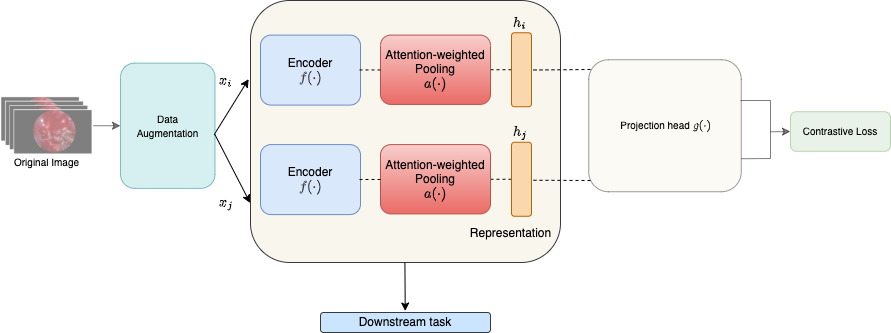

In [1]:
import torch
import torchvision
import pandas as pd
from skimage import io, transform, util
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import pytorch_lightning as pl
from PIL import Image
import random
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler

# PyTorch Lightning
import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint, EarlyStopping

Device: cuda:0
Number of workers: 16


## 1. Data Augmentation for Contrastive Learning

In [2]:
class ContrastiveTransformations:
    """
    A stochastic data augmentation module
    Transforms any given data example randomly
    resulting in two correlated views of the same example,
    denoted x ̃i and x ̃j, which we consider as a positive pair.
    """
    def __init__(self, base_transforms, n_views=2):
        self.base_transforms = base_transforms
        self.n_views = n_views

    def __call__(self, sample):
        image, label = sample['image'], sample['label']

        # Convert NumPy array to PIL Image if necessary
        if isinstance(image, np.ndarray):
            image_pil = Image.fromarray(image)
        else:
            image_pil = image

        # Apply base transformations to create two views
        transformed_images = [self.base_transforms(image_pil) for _ in range(self.n_views)]
        
        return {'image': transformed_images, 'label': label}

In [3]:
# Define SimCLR augmentations
simclr_transform = transforms.Compose([
    transforms.RandomCrop(size=224),
    transforms.RandomApply([transforms.RandomResize(size=224)], p=0.3),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomApply([transforms.ColorJitter(brightness=0.5, 
                                                   contrast=0.5, saturation=0.5, 
                                                   hue=0.1)], p=0.8),
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0))], p=0.3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.312, 0.120, 0.117], std=[0.280, 0.158, 0.160])])

contrastive_augment = ContrastiveTransformations(simclr_transform, n_views=2)

## 2. SimCLR Implementation

### Load dataset

In [4]:
class PituDataset(Dataset):
    """Pituitary Endoscopy dataset."""

    def __init__(self, csv_file, root_dir, transform=None, maxSize=0, unlabeled=False):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
            maxSize (int, optional): Maximum size of the dataset (number of samples).
            unlabeled (bool, optional): If True, ignore labels.
        """
        self.dataset = pd.read_csv(csv_file, header=0, dtype={'id': str, 'label': int})
        
        if maxSize > 0:
            newDatasetSize = maxSize  # maxSize samples (Parameter to select a specific number of images)
            idx = np.random.RandomState(seed=42).permutation(range(len(self.dataset)))
            reduced_dataset = self.dataset.iloc[idx[0:newDatasetSize]]
            self.dataset = reduced_dataset.reset_index(drop=True)

        self.root_dir = root_dir
        self.img_dir = os.path.join(root_dir, 'images')
        self.transform = transform
        self.unlabeled = unlabeled
        self.classes = ['Desconocida', 'Preparacion colgajo', 'Etmoidectomia', 'Apertura selar', 
                        'Apertura dural', 'Reseccion tumoral', 'Cierre']

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        # Read the image
        img_name = os.path.join(self.img_dir, self.dataset.id[idx] + '.png')
        image = io.imread(img_name)
        
        if self.unlabeled:
            sample = {'image': image, 'label': np.int64(-1)}  # Use -1 to indicate unlabeled, keep datatype
        else:
            sample = {'image': image, 'label': self.dataset.label[idx].astype(dtype=np.long)}
        
        if self.transform:
            sample = self.transform(sample)
        return sample 

In [6]:
# Train Dataset
unlabeled_train_dataset = PituDataset(csv_file="/home/train_set.csv",
                                      root_dir='/home',
                                      #maxSize=100000,
                                      transform=contrastive_augment,
                                      unlabeled=True)

# Validation Dataset
val_dataset = PituDataset(csv_file="/home/acenteno/val_set.csv",
                          root_dir='/home',
                          transform=contrastive_augment)

### Define the Attention-weighted Pooling Layer

In [5]:
class AttentionWeightedPooling(nn.Module):
    def __init__(self, input_dim):
        super(AttentionWeightedPooling, self).__init__()
        
        # Apply three consecutive convolution blocks (convolution, batch norm, ReLU activation)
        # with decreasing number of filters 
        # and then one final convolution with one filter (sigmoid activation)
        
        self.conv1 = nn.Conv2d(input_dim, input_dim // 2, kernel_size=1, padding='same')
        self.bn1 = nn.BatchNorm2d(input_dim // 2)
        self.relu1 = nn.ReLU()
        
        self.conv2 = nn.Conv2d(input_dim // 2, input_dim // 4, kernel_size=1, padding='same')
        self.bn2 = nn.BatchNorm2d(input_dim // 4)
        self.relu2 = nn.ReLU()
        
        self.conv3 = nn.Conv2d(input_dim // 4, input_dim // 8, kernel_size=1, padding='same')
        self.bn3 = nn.BatchNorm2d(input_dim // 8)
        self.relu3 = nn.ReLU()
        
        self.attn_conv = nn.Conv2d(input_dim // 8, 1, kernel_size=1, padding='valid')
        
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
    
    def forward(self, x):
        attn = self.relu1(self.bn1(self.conv1(x)))
        attn = self.relu2(self.bn2(self.conv2(attn)))
        attn = self.relu3(self.bn3(self.conv3(attn)))
        attn = torch.sigmoid(self.attn_conv(attn))
        
        attn_up = attn * x
        
        gap_features = self.global_avg_pool(attn_up)
        gap_mask = self.global_avg_pool(attn)
        
        gap_features = gap_features / gap_mask
        return gap_features.squeeze()

### Define SimCLR Class

In [6]:
class SimCLR(pl.LightningModule):
    
    def __init__(self, hidden_dim, lr, temperature, weight_decay, max_epochs=500):
        super().__init__()
        self.save_hyperparameters()
        assert self.hparams.temperature > 0.0, 'The temperature must be a positive float!'
        
        # Base model f(.)
        self.convnet = torchvision.models.resnet50(pretrained=False)
        self.features = nn.Sequential(*list(self.convnet.children())[:-2]) # remove last classification layer
        in_features = self.convnet.fc.in_features  # 2048

        # Add attention pooling layer a(.)
        self.attn_pooling = AttentionWeightedPooling(in_features) #(this is vector h)
        
        # The MLP for g(.) consists of Linear->ReLU->Linear
        self.projection_head = nn.Sequential(
            nn.Linear(in_features, 4 * hidden_dim),  # Linear(2048, 4*hidden_dim)
            nn.ReLU(inplace=True),
            nn.Linear(4 * hidden_dim, hidden_dim)  # Linear(4*hidden_dim, hidden_dim) (this is vector g)
        )

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=self.hparams.lr, weight_decay=self.hparams.weight_decay)
        lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=self.hparams.max_epochs, eta_min=self.hparams.lr / 50)
        return [optimizer], [lr_scheduler]

    def info_nce_loss(self, batch, mode='train'):
        imgs = torch.cat(batch['image'], dim=0)
        imgs = imgs.to(device=self.device, dtype=torch.float)

        # Encode all images using convnet up to the layer before the fully connected layer
        feats = self.features(imgs)
        
        # apply attention layer
        feats = self.attn_pooling(feats)
        
        # Apply projection head
        feats = self.projection_head(feats)

        # Calculate cosine similarity
        cos_sim = F.cosine_similarity(feats[:, None, :], feats[None, :, :], dim=-1)

        # Mask out cosine similarity to itself
        self_mask = torch.eye(cos_sim.shape[0], dtype=torch.bool, device=cos_sim.device)
        cos_sim.masked_fill_(self_mask, -9e15)

        # Find positive example -> batch_size//2 away from the original example
        pos_mask = self_mask.roll(shifts=cos_sim.shape[0] // 2, dims=0)

        # InfoNCE loss
        cos_sim = cos_sim / self.hparams.temperature
        nll = -cos_sim[pos_mask] + torch.logsumexp(cos_sim, dim=-1)
        nll = nll.mean()
        
        ###--- Log metrics ---###

        # Logging loss
        self.log(f'{mode}_loss', nll)
        
        # Get ranking position of positive example
        comb_sim = torch.cat([cos_sim[pos_mask][:, None], cos_sim.masked_fill(pos_mask, -9e15)], dim=-1)
        sim_argsort = comb_sim.argsort(dim=-1, descending=True).argmin(dim=-1)
        
        # Logging ranking metrics
        self.log(f'{mode}_acc_top1', (sim_argsort == 0).float().mean())
        self.log(f'{mode}_acc_top5', (sim_argsort < 5).float().mean())
        self.log(f'{mode}_acc_mean_pos', 1 + sim_argsort.float().mean())

        return nll

    def training_step(self, batch, batch_idx):
        return self.info_nce_loss(batch, mode='train')

    def validation_step(self, batch, batch_idx):
        self.info_nce_loss(batch, mode='val')

    def get_features(self, x):
        # Extract features using convnet up to the layer before the fully connected layer
        features = self.features(x)
        features = self.attn_pooling(features)
        return features

    def forward(self, x):
        # Standard forward pass through the convnet and fully connected layer
        return self.convnet(x)


### Pre-Training

In [9]:
# sin checkpoints
def train_simclr(batch_size, max_epochs=5, **kwargs):
    trainer = pl.Trainer(default_root_dir='/home/simclr_models',
                         accelerator="gpu",
                         devices=1,
                         max_epochs=max_epochs,
                         callbacks=[ModelCheckpoint(save_weights_only=True, mode='max', monitor='val_loss'),
                                    LearningRateMonitor('epoch'),EarlyStopping(monitor="val_loss", patience=3, mode="min")])
    
    trainer.logger._default_hp_metric = None # Optional logging argument that we don't need

    train_loader = DataLoader(unlabeled_train_dataset, batch_size=batch_size, shuffle=True, 
                                    drop_last=True, pin_memory=True, num_workers=NUM_WORKERS)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, 
                                    drop_last=False, pin_memory=True, num_workers=NUM_WORKERS)

    pl.seed_everything(42) # To be reproducable

    model = SimCLR(max_epochs=max_epochs, **kwargs)
    trainer.fit(model, train_loader, val_loader)
    
    model = SimCLR.load_from_checkpoint(trainer.checkpoint_callback.best_model_path) # Load best checkpoint after training

    return model

In [10]:
simclr_model = train_simclr(batch_size=64, 
                            hidden_dim=128, 
                            lr=5e-4, 
                            temperature=0.07, 
                            weight_decay=1e-4, 
                            max_epochs=100)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Global seed set to 42
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type   | Params
-----------------------------------
0 | convnet | ResNet | 24.6 M
-----------------------------------
24.6 M    Trainable params
0         Non-trainable params
24.6 M    Total params
98.491    Total estimated model params size (MB)
2024-10-21 13:09:27.882479: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library 

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

IsADirectoryError: [Errno 21] Is a directory: '/home/acenteno'

In [ ]:
# Save the model
save_dir = '/home/simclr_models'
os.makedirs(save_dir, exist_ok=True)

# Define the path 
save_path = os.path.join(save_dir, 'simclr_attention_model.pt')

# Save the model's state dictionary
torch.save(simclr_model.state_dict(), save_path)

print(f"Best model saved to {save_path}")